In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

import open3d as o3d

from scipy.spatial import procrustes
from copy import deepcopy

from tqdm.notebook import tqdm

In [5]:
from fundamental_matrix import keypoint_matcher, get_fundamental_matrix, get_fundamental_matrix_ransac

# Matching

In [ ]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")

Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 0.15: 450. After: 18
Have 18 matches while asking for n_points=20


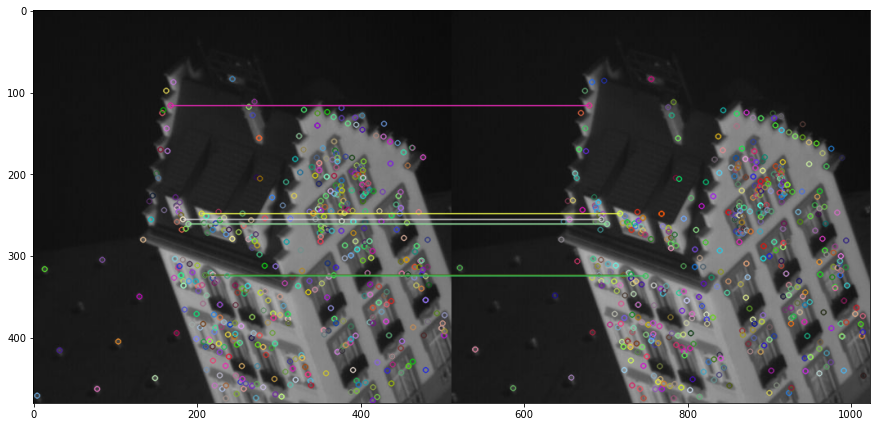

In [25]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=20, 
                                                                       distance_threshold=0.15,
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=True)

In [26]:
[m[0].distance for m in matches]

[8.426149368286133,
 10.488088607788086,
 11.401754379272461,
 13.190905570983887,
 15.0,
 15.033296585083008,
 15.459625244140625,
 16.970561981201172,
 18.055469512939453,
 18.867961883544922,
 22.516660690307617,
 28.301942825317383,
 28.809720993041992,
 31.160873413085938,
 32.06243896484375,
 33.09078598022461,
 73.25981140136719,
 77.88452911376953]

In [27]:
[np.linalg.norm(np.array(p1)-np.array(p2)) for p1, p2 in zip(matched_points1, matched_points2)]

[0.13470990127718457,
 0.09231244546589051,
 0.13470990127718457,
 0.1463027408161432,
 0.14256826866387934,
 0.10113406713016168,
 0.09231244546589051,
 0.127810474535054,
 0.034843497446453535,
 0.054650813808406654,
 0.05055173256909472,
 0.1364783463964474,
 0.09107805666934866,
 0.14866772165275172,
 0.116312499505227,
 0.1463027408161432,
 0.08200815562588643,
 0.13016909137113863]

In [28]:
sorted(matched_points1, key=lambda x: x[0])

[(150.70590209960938, 199.20382690429688),
 (152.74134826660156, 204.7090301513672),
 (167.96371459960938, 116.2098159790039),
 (167.96371459960938, 116.2098159790039),
 (175.68380737304688, 258.3050231933594),
 (175.88623046875, 241.01461791992188),
 (180.70162963867188, 250.08480834960938),
 (181.65159606933594, 267.8046875),
 (182.92825317382812, 255.20550537109375),
 (189.71798706054688, 260.8363037109375),
 (189.71798706054688, 260.8363037109375),
 (201.5600128173828, 336.95306396484375),
 (205.81719970703125, 248.2129669189453),
 (210.1157989501953, 323.3241882324219),
 (210.1157989501953, 323.3241882324219),
 (237.13021850585938, 324.23199462890625),
 (247.0077667236328, 335.88104248046875),
 (262.20440673828125, 336.5632019042969)]

In [29]:
sorted(matched_points2, key=lambda x: x[0])

[(150.79600524902344, 199.2171173095703),
 (152.6868438720703, 204.7050323486328),
 (168.09413146972656, 116.17607879638672),
 (168.09413146972656, 116.17607879638672),
 (175.7934112548828, 258.23480224609375),
 (175.96380615234375, 241.0412139892578),
 (180.5725555419922, 250.129150390625),
 (181.68084716796875, 267.8459167480469),
 (183.0542449951172, 255.22698974609375),
 (189.80917358398438, 260.8506774902344),
 (189.80917358398438, 260.8506774902344),
 (201.4286651611328, 337.022705078125),
 (205.90496826171875, 248.1627197265625),
 (210.0010986328125, 323.4150085449219),
 (210.0010986328125, 323.4150085449219),
 (237.08387756347656, 324.3668212890625),
 (247.01353454589844, 335.8466796875),
 (262.202880859375, 336.67950439453125)]

# Normalization

In [30]:
from fundamental_matrix import normalize_points

In [31]:
matched_points1_norm, T = normalize_points(matched_points1)

mean x: 193.867, mean y: 258.828, average distance to the mean: 57.207


Check and show that the set of points {p_hat} with homogeneous coordinates satisfies our criteria.

In [32]:
normalize_points(matched_points1_norm);

mean x: -0.0, mean y: 0.0, average distance to the mean: 1.414


In [33]:
matched_points2_norm, T_prime = normalize_points(matched_points2)

mean x: 193.888, mean y: 258.853, average distance to the mean: 57.213


In [34]:
normalize_points(matched_points2_norm);

mean x: 0.0, mean y: -0.0, average distance to the mean: 1.414


# Fundamental matrix

In [35]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=-1, 
                                                                       distance_threshold=0.5,
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=False)

Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 0.5: 450. After: 113


In [36]:
len(matches)

113

In [45]:
from fundamental_matrix import random_colors, drawlines

## Regular 8 point algorithm

U, D, V_t = np.linalg.svd(A) (113, 113) (9,) (9, 9)
V_t.T[:, n - 1]
[-6.56291067e-07  1.47351407e-03 -5.35549809e-01 -1.47462528e-03
 -1.00547474e-06  4.34603248e-01  5.36044364e-01 -4.33568999e-01
 -2.21306205e-01]
(9,)
F
[[-6.56291067e-07  1.47351407e-03 -5.35549809e-01]
 [-1.47462528e-03 -1.00547474e-06  4.34603248e-01]
 [ 5.36044364e-01 -4.33568999e-01 -2.21306205e-01]]
(3, 3)
FD_prime [8.09048867e-01 5.87741381e-01 3.85498026e-08]
FD_prime with the smallest singular value zeroed [0.80904887 0.58774138 0.        ]


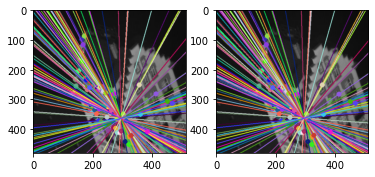

In [58]:
# Regular 8 point algorithm
F = get_fundamental_matrix(matched_points1, matched_points2, normalize=False)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
colors = random_colors(lines1)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point.png', final)
plt.show()

In [59]:
F

array([[-6.41014955e-07,  1.47353293e-03, -5.35549809e-01],
       [-1.47460642e-03, -9.82201230e-07,  4.34603248e-01],
       [ 5.36044364e-01, -4.33568999e-01, -2.21306205e-01]])

In [60]:
F_cv = cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_8POINT)[0]
F_cv

array([[-6.81038212e-06,  3.92929241e-03, -2.25240538e+00],
       [-3.90812073e-03, -7.18700520e-06,  1.82520826e+00],
       [ 2.25170564e+00, -1.82954606e+00,  1.00000000e+00]])

Similar, but not the same

## 8 point algorithm with normalization

mean x: 233.632, mean y: 311.445, average distance to the mean: 84.614
mean x: 233.582, mean y: 311.556, average distance to the mean: 84.708
U, D, V_t = np.linalg.svd(A) (113, 113) (9,) (9, 9)
V_t.T[:, n - 1]
[-2.67981289e-04 -1.18525526e-01  5.22474089e-01  1.19028004e-01
 -2.96577430e-04 -4.62520992e-01 -5.21932529e-01  4.60938830e-01
  9.28662434e-04]
(9,)
F
[[-2.67981289e-04 -1.18525526e-01  5.22474089e-01]
 [ 1.19028004e-01 -2.96577430e-04 -4.62520992e-01]
 [-5.21932529e-01  4.60938830e-01  9.28662434e-04]]
(3, 3)
FD_prime [7.08163100e-01 7.06048868e-01 1.44368862e-04]
FD_prime with the smallest singular value zeroed [0.7081631  0.70604887 0.        ]


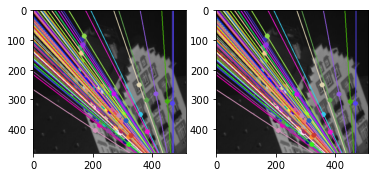

In [64]:
# 8 point algorithm with normalization
F = get_fundamental_matrix(matched_points1, matched_points2, normalize=True)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point_normalized.png', final)
plt.show()

In [65]:
F

array([[-5.76006090e-08, -3.30539653e-05,  1.90310306e-02],
       [ 3.32330304e-05, -6.07859984e-08, -1.54669709e-02],
       [-1.90636953e-02,  1.54440749e-02,  1.30040006e-02]])

In [66]:
F_cv

array([[-6.81038212e-06,  3.92929241e-03, -2.25240538e+00],
       [-3.90812073e-03, -7.18700520e-06,  1.82520826e+00],
       [ 2.25170564e+00, -1.82954606e+00,  1.00000000e+00]])

## 8 point algoirhtm with RANSAC and normalization

mean x: 262.262, mean y: 364.106, average distance to the mean: 82.761
mean x: 261.993, mean y: 364.299, average distance to the mean: 82.908
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-3.59007321e-04 -3.48205364e-01  6.16630906e-01  3.52855764e-01
 -3.60404880e-03 -4.50575805e-03 -6.11524489e-01 -3.66964348e-04
  4.05030717e-03]
(9,)
F
[[-3.59007321e-04 -3.48205364e-01  6.16630906e-01]
 [ 3.52855764e-01 -3.60404880e-03 -4.50575805e-03]
 [-6.11524489e-01 -3.66964348e-04  4.05030717e-03]]
(3, 3)
FD_prime [0.70964957 0.70454456 0.00380148]
FD_prime with the smallest singular value zeroed [0.70964957 0.70454456 0.        ]
new best number of inliers 109
mean x: 255.62, mean y: 306.7, average distance to the mean: 107.023
mean x: 255.6, mean y: 306.754, average distance to the mean: 107.27
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.00224906 -0.45388356 -0.41363134  0.45217203  0.00320375  0.35527974
  0.41149275 -0.35051539 -0.00359696]
(9,)
F

mean x: 204.788, mean y: 263.997, average distance to the mean: 72.369
mean x: 204.834, mean y: 264.078, average distance to the mean: 72.479
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 2.18002831e-03  4.97499781e-02 -9.70419711e-02 -5.21761682e-02
  5.18138310e-04  6.97932241e-01  9.93849543e-02 -6.98851497e-01
 -4.73310673e-04]
(9,)
F
[[ 2.18002831e-03  4.97499781e-02 -9.70419711e-02]
 [-5.21761682e-02  5.18138310e-04  6.97932241e-01]
 [ 9.93849543e-02 -6.98851497e-01 -4.73310673e-04]]
(3, 3)
FD_prime [0.7080169  0.70619277 0.00195892]
FD_prime with the smallest singular value zeroed [0.7080169  0.70619277 0.        ]
mean x: 230.653, mean y: 311.648, average distance to the mean: 88.859
mean x: 230.518, mean y: 311.64, average distance to the mean: 88.813
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.00169418  0.23192471  0.66397577 -0.22930863 -0.00162778 -0.09116974
 -0.66087232  0.08771312  0.00117836]
(9,)
F
[[-0.00169418  0.23192471  

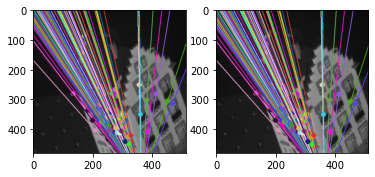

In [67]:
# 8 point algoirhtm with RANSAC and normalization
F = get_fundamental_matrix_ransac(matched_points1, matched_points2)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point_normalized_ransac.png', final)
plt.show()

In [68]:
F

array([[ 7.62323636e-08,  3.26937123e-05, -1.89936084e-02],
       [-3.29269845e-05,  4.67230134e-08,  1.19051916e-02],
       [ 1.90117170e-02, -1.18580179e-02, -1.06235593e-02]])

In [69]:
cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_RANSAC, 1)[0]

array([[ 1.00239540e-06,  1.57043794e-02, -5.84523696e+00],
       [-1.57315625e-02,  4.24660273e-05,  3.55406596e+00],
       [ 5.85859020e+00, -3.57466984e+00,  1.00000000e+00]])

# Chaining

Construct a point-view matrix for chaining multiple views with the matches found in last step using all consecutive house images (1-2, 2-3, 3-4, ..., 48-49, 49-1). Rows of the point-view matrix will be representing your images while columns will be points. For more details, you can refer to [2].
1. Start from any two consecutive image matches. Add a new column to point-view matrix for each newly introduced point.
2. If a point which is already introduced in the point-view matrix and another image contains that point, mark this matching on your point-view matrix using the previously defined point column. Do not introduce a new column.  

Together with the assignment a sample point view matrix (PointViewMatrix.txt) is provided to test and finish your pipeline (for the ones who have difficult time to build a point view matrix). This data has more images than provided for the assignment, however you can still use PVM to check correctness of the last part of your algorithm.

In [6]:
from chaining import get_names_image_pair, chaining

In [7]:
sparse_fill_value=-1e-4

In [8]:
PVM = chaining(sparse_fill_value=sparse_fill_value, n_points=500, 
               filter_neighbours=True, distance_threshold=1,) # a lot of points but very careful

100%|██████████| 48/48 [00:07<00:00,  6.79it/s]


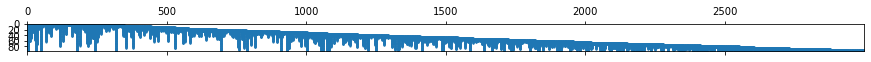

In [9]:
# Implementation of matplotlib spy function
import matplotlib.pyplot as plt
import numpy as np
 
    
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=-sparse_fill_value, markersize = 1);

In [10]:
PVM.shape

(98, 2998)

In [11]:
def calc_sparsity(matrix, sparse_value=0):
    shape = matrix.shape
    return np.sum(matrix == sparse_value) / (shape[0] * shape[1])

In [12]:
calc_sparsity(PVM, sparse_fill_value)

0.9020571537487577

## Densification

### Hyper-parameter grid search

In [95]:
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm

best_params = None
lowest_sparsity = 1
best_PVM = None

param_grid = {'n_points': [100, 200, 300, 400, 500, 600], 
              'filter_neighbours': [True, False],
              'distance_threshold': [0.25, 0.5, 1, 10, 20]
              }
param_list = list(ParameterGrid(param_grid))
for param_set in tqdm(param_list, total=len(param_list)):
    PVM = chaining(sparse_fill_value=sparse_fill_value, **param_set) 
    sparsity = calc_sparsity(PVM, sparse_fill_value)
    
    if sparsity < lowest_sparsity:
        lowest_sparsity = sparsity
        best_params = param_set
        best_PVM = PVM

  0%|          | 0/60 [00:00<?, ?it/s]


100%|██████████| 48/48 [00:06<00:00,  7.90it/s]

100%|██████████| 48/48 [00:05<00:00,  8.13it/s]

100%|██████████| 48/48 [00:06<00:00,  7.80it/s]

 31%|███▏      | 15/48 [00:01<00:04,  8.13it/s]


100%|██████████| 48/48 [00:06<00:00,  7.84it/s]

100%|██████████| 48/48 [00:05<00:00,  8.05it/s]

100%|██████████| 48/48 [00:05<00:00,  8.57it/s]

 60%|██████    | 29/48 [00:03<00:02,  8.39it/s]


100%|██████████| 48/48 [00:05<00:00,  8.30it/s]

100%|██████████| 48/48 [00:05<00:00,  8.44it/s]

100%|██████████| 48/48 [00:05<00:00,  8.42it/s]

 94%|█████████▍| 45/48 [00:05<00:00,  8.26it/s]


100%|██████████| 48/48 [00:05<00:00,  8.16it/s]

100%|██████████| 48/48 [00:05<00:00,  8.11it/s]

100%|██████████| 48/48 [00:05<00:00,  8.16it/s]

100%|██████████| 48/48 [00:06<00:00,  7.96it/s]

 23%|██▎       | 11/48 [00:01<00:04,  7.81it/s]


100%|██████████| 48/48 [00:05<00:00,  8.18it/s]

100%|██████████| 48/48 [00:05<00:00,  8.19it/s]

100%|██████████| 48/48 [00:05<00:00,  8.19it/s]

 52%|█████▏    | 25/48 [00:02<00:02,  8.68it/s]


100%|██████████| 48/48 [00:05<00:00,  8.16it/s]

100%|██████████| 48/48 [00:06<00:00,  7.86it/s]

100%|██████████| 48/48 [00:06<00:00,  7.89it/s]

 81%|████████▏ | 39/48 [00:04<00:01,  6.52it/s]


100%|██████████| 48/48 [00:06<00:00,  7.47it/s]

100%|██████████| 48/48 [00:06<00:00,  7.80it/s]

100%|██████████| 48/48 [00:06<00:00,  7.73it/s]

100%|██████████| 48/48 [00:06<00:00,  7.96it/s]

 10%|█         | 5/48 [00:00<00:04,  9.02it/s]


100%|██████████| 48/48 [00:05<00:00,  8.03it/s]

100%|██████████| 48/48 [00:06<00:00,  7.95it/s]

100%|██████████| 48/48 [00:07<00:00,  6.78it/s]

 40%|███▉      | 19/48 [00:02<00:04,  7.05it/s]


100%|██████████| 48/48 [00:07<00:00,  6.49it/s]

100%|██████████| 48/48 [00:07<00:00,  6.52it/s]

100%|██████████| 48/48 [00:07<00:00,  6.34it/s]

 69%|██████▉   | 33/48 [00:04<00:02,  6.38it/s]


100%|██████████| 48/48 [00:07<00:00,  6.37it/s]

100%|██████████| 48/48 [00:06<00:00,  7.47it/s]

100%|██████████| 48/48 [00:07<00:00,  6.41it/s]

 98%|█████████▊| 47/48 [00:07<00:00,  4.93it/s]


100%|██████████| 48/48 [00:07<00:00,  6.37it/s]

100%|██████████| 48/48 [00:07<00:00,  6.46it/s]

100%|██████████| 48/48 [00:07<00:00,  6.55it/s]

100%|██████████| 48/48 [00:07<00:00,  6.59it/s]

 25%|██▌       | 12/48 [00:01<00:04,  7.78it/s]


100%|██████████| 48/48 [00:06<00:00,  7.63it/s]

100%|██████████| 48/48 [00:07<00:00,  6.23it/s]

100%|██████████| 48/48 [00:08<00:00,  5.81it/s]

 54%|█████▍    | 26/48 [00:03<00:03,  6.51it/s]


100%|██████████| 48/48 [00:07<00:00,  6.11it/s]

100%|██████████| 48/48 [00:07<00:00,  6.01it/s]

100%|██████████| 48/48 [00:08<00:00,  5.90it/s]

 83%|████████▎ | 40/48 [00:05<00:01,  7.26it/s]


100%|██████████| 48/48 [00:06<00:00,  7.69it/s]

100%|██████████| 48/48 [00:07<00:00,  6.24it/s]

100%|██████████| 48/48 [00:08<00:00,  5.69it/s]

100%|██████████| 48/48 [00:08<00:00,  5.90it/s]

 10%|█         | 5/48 [00:00<00:05,  7.87it/s]


100%|██████████| 48/48 [00:07<00:00,  6.03it/s]

100%|██████████| 48/48 [00:08<00:00,  5.58it/s]

100%|██████████| 48/48 [00:06<00:00,  7.32it/s]

 40%|███▉      | 19/48 [00:02<00:04,  6.80it/s]


100%|██████████| 48/48 [00:08<00:00,  5.42it/s]

100%|██████████| 48/48 [00:09<00:00,  5.09it/s]

100%|██████████| 48/48 [00:10<00:00,  4.58it/s]

 69%|██████▉   | 33/48 [00:05<00:03,  4.84it/s]


100%|██████████| 48/48 [00:09<00:00,  5.21it/s]

100%|██████████| 48/48 [00:08<00:00,  5.75it/s]

100%|██████████| 48/48 [00:06<00:00,  7.36it/s]

 98%|█████████▊| 47/48 [00:08<00:00,  4.50it/s]


100%|██████████| 48/48 [00:08<00:00,  5.65it/s]

100%|██████████| 48/48 [00:08<00:00,  5.45it/s]

100%|██████████| 48/48 [00:08<00:00,  5.65it/s]

100%|██████████| 48/48 [00:08<00:00,  5.41it/s]

 25%|██▌       | 12/48 [00:01<00:05,  6.73it/s]


100%|██████████| 48/48 [00:08<00:00,  5.81it/s]


In [96]:
lowest_sparsity

0.8557855611548849

In [97]:
best_params

{'distance_threshold': 20, 'filter_neighbours': False, 'n_points': 500}

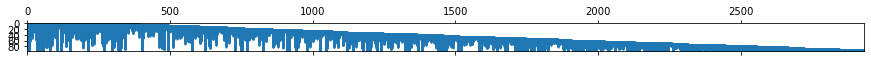

In [98]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=-sparse_fill_value, markersize = 1);

when we allow all the garbage points to be presented, we obtain the best results

### Drop bad cols

In [13]:
column_pureness = 0.5
cols_to_keep = []
for i in range(PVM.shape[1]):
    if np.sum(PVM[:, i] == sparse_fill_value) < PVM.shape[0]*0.5:
        cols_to_keep.append(i)
PVM.shape, len(cols_to_keep)

((98, 2998), 60)

In [14]:
PVM_dense_cols = PVM[:, cols_to_keep]
PVM_dense_cols.shape

(98, 60)

In [15]:
calc_sparsity(PVM_dense_cols, sparse_fill_value)

0.32108843537414966

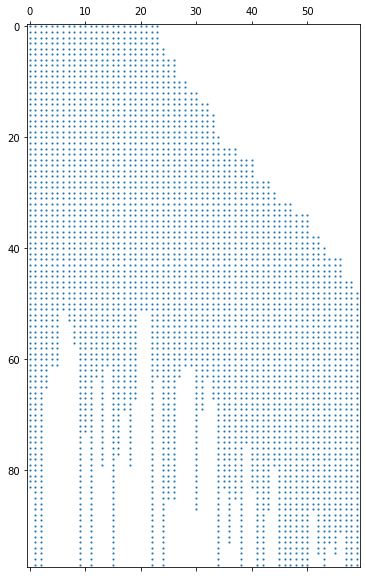

In [16]:
plt.figure(figsize=(15, 10))
plt.spy(PVM_dense_cols, precision=-sparse_fill_value, markersize = 1);

## Comparing with PointViewMatrix.txt

In [12]:
gt_pvm = np.loadtxt('../PointViewMatrix.txt')
gt_pvm.shape

(202, 215)

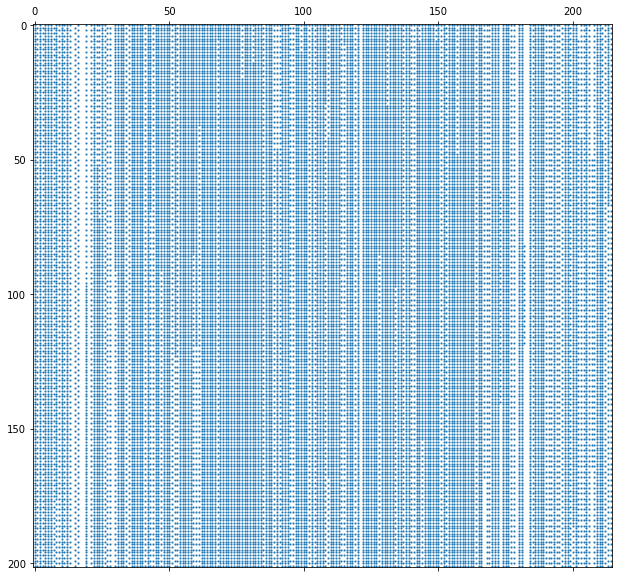

In [13]:
plt.figure(figsize=(15, 10))
plt.spy(gt_pvm, precision=200, markersize = 1);

Q: how to extract dense blocks?

# Chaining check

Before filtering neighbours: 543. After: 450
Before filtering neighbours: 548. After: 447


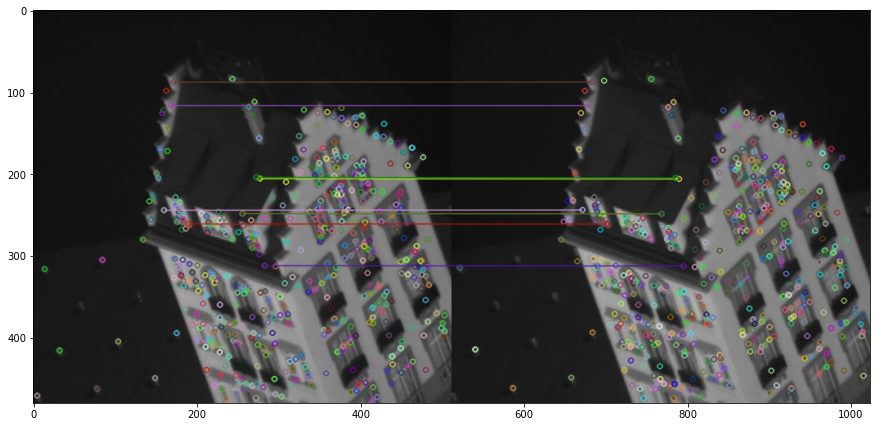

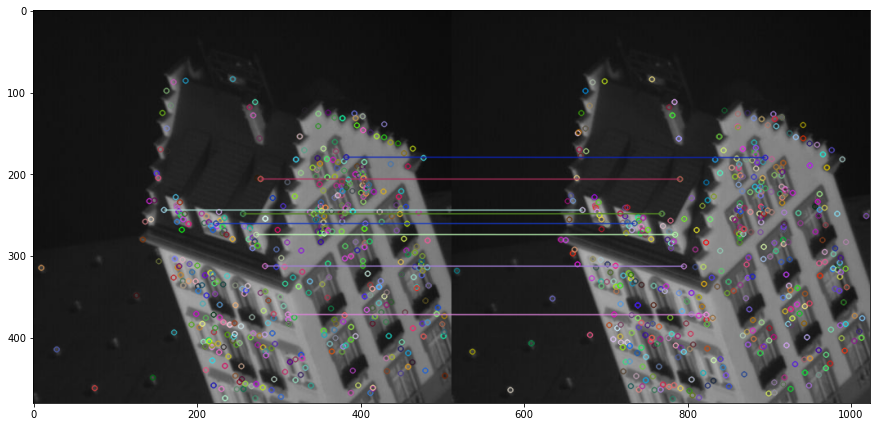

In [141]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")
image3 = cv.imread("../Data/House/frame00000003.png")

_, matched_points12, matched_points21, _, _ = keypoint_matcher(
    image1, image2, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

_, matched_points23, matched_points32, _, _ = keypoint_matcher(
    image2, image3, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

In [144]:
sorted(matched_points21, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (168.09413146972656, 116.17607879638672),
 (171.5107879638672, 87.54129791259766),
 (189.80917358398438, 260.8506774902344),
 (256.4742431640625, 248.44085693359375),
 (273.99774169921875, 204.6702880859375),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875)]

In [145]:
sorted(matched_points23, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (223.43911743164062, 260.18743896484375),
 (256.4742431640625, 248.44085693359375),
 (272.61663818359375, 273.8099670410156),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875),
 (311.4600830078125, 371.3696594238281),
 (382.78680419921875, 179.23373413085938)]

In [11]:
PVM[2, :20]

array([ 2.77999908e+02,  1.59843262e+02,  1.68094131e+02,  2.73997742e+02,
        2.83414673e+02,  1.89809174e+02,  1.71510788e+02,  2.56474243e+02,
        2.23439117e+02,  3.82786804e+02,  2.77999908e+02,  2.72616638e+02,
        2.83414673e+02,  3.11460083e+02,  2.56474243e+02,  1.59843262e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

In [12]:
PVM[3, :20]

array([ 2.05904709e+02,  2.43742966e+02,  1.16176079e+02,  2.04670288e+02,
        3.12281128e+02,  2.60850677e+02,  8.75412979e+01,  2.48440857e+02,
        2.60187439e+02,  1.79233734e+02,  2.05904709e+02,  2.73809967e+02,
        3.12281128e+02,  3.71369659e+02,  2.48440857e+02,  2.43742966e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

# Structure from motion

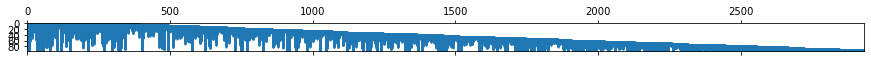

In [119]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

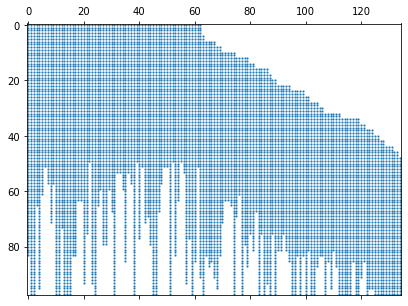

In [121]:
plt.figure(figsize=(15, 5))
plt.spy(PVM_dense_cols, precision=1e-4, markersize = 1);

In [18]:
from sfm import factorize_and_stitch

## GT PVM

In [15]:
gt_pvm.shape

(202, 215)

### Full

In [16]:
S = factorize_and_stitch(gt_pvm)
S.shape

2m:  202
n:  215


(3, 215)

In [17]:
trace_S = (S @ S.T).trace()
S_stand = S / np.sqrt(trace_S)

In [21]:
gt_pvm_point = o3d.geometry.PointCloud()
gt_pvm_point.points = o3d.utility.Vector3dVector(S_stand.T)
o3d.visualization.draw_geometries([gt_pvm_point])    

works perfect

### Vetrical split

In [22]:
S1 = factorize_and_stitch(gt_pvm[:, :100])
S2 = factorize_and_stitch(gt_pvm[:, 100: 200])
S1.shape, S2.shape

2m:  202
n:  100
2m:  202
n:  100


((3, 100), (3, 100))

In [25]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [26]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([p1, p2]) 

In [449]:
o3d.visualization.draw_geometries([gt_pvm_point, p2]) 

works bad

### Horizontal halfs

In [27]:
S1 = factorize_and_stitch(gt_pvm[:100, :])
S2 = factorize_and_stitch(gt_pvm[100: 200, :])
S1.shape, S2.shape

2m:  100
n:  215
2m:  100
n:  215


((3, 215), (3, 215))

In [28]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [29]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([gt_pvm_point, p1, p2]) 

works pretty well

### 3 horizontal parts alligned to the first

In [30]:
gt_pvm.shape

(202, 215)

In [31]:
S1 = factorize_and_stitch(gt_pvm[:65, :])
S2 = factorize_and_stitch(gt_pvm[65: 130, :])
S3 = factorize_and_stitch(gt_pvm[130: 195, :])
S1.shape, S2.shape, S3.shape

2m:  65
n:  215
2m:  65
n:  215
2m:  65
n:  215


((3, 215), (3, 215), (3, 215))

In [32]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [33]:
mtx1, mtx3, disparity = procrustes(S1.T, S3.T)

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [34]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

works pretty well

### 3 horizontal parts alligned cumulatively

In [35]:
mtx1.shape, mtx2_stand.shape, S3.T.shape

((215, 3), (215, 3), (215, 3))

In [36]:
np.vstack([mtx1, mtx2_stand]).shape

(430, 3)

In [39]:
np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0).shape

(430, 3)

In [40]:
mtx1, mtx3, disparity = procrustes(np.vstack([mtx1, mtx2_stand]),
                                   np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0))

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)

In [41]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

also well

## 3 images

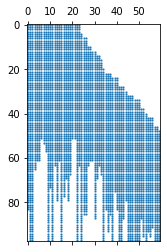

In [19]:
plt.figure(figsize=(15, 4))
plt.spy(PVM_dense_cols, precision=1e-4, markersize = 1);

Briefly, we find a dense block for each patch—that is, for each column in the patch-view matrix—by searching for all other patches that are visible in at least the same views. In practice, this strategy provides both a good coverage of the data by dense blocks, and an adequate overlap between blocks. Typically, patches appear in at least three or four views, depending on the separation between successive views in the sequence, and there are in general two orders of magnitude more patches than views.

In [20]:
from sfm import extract_dense_blocks
min_number_of_patches = 3
min_number_of_images = 3


dense_blocks_list = extract_dense_blocks(PVM_dense_cols, min_number_of_images=min_number_of_images,
                                         min_number_of_patches=min_number_of_patches,
                                         sparse_fill_value=sparse_fill_value)

in column 0 the longest sequence indices: [ 0 84]
dense block is rising
dense block is rising
in column 1 the longest sequence indices: [ 0 98]
dense block is rising
do not make a dense matrix from one patch
in column 2 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 3 the longest sequence indices: [ 0 66]
do not make a dense matrix from one patch
in column 4 the longest sequence indices: [ 0 62]
dense block is rising
do not make a dense matrix from one patch
in column 5 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 6 the longest sequence indices: [ 0 52]
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising


  0%|          | 0/10 [00:00<?, ?it/s]

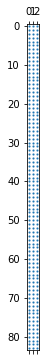

2m:  84
n:  3


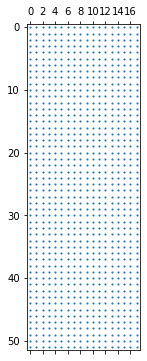

2m:  52
n:  18


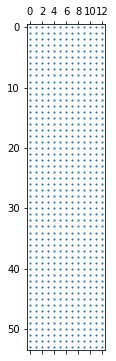

2m:  54
n:  13


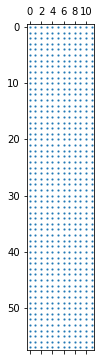

2m:  58
n:  12


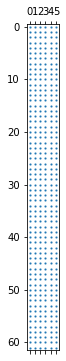

2m:  62
n:  6


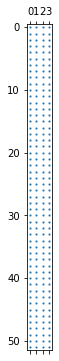

2m:  52
n:  4


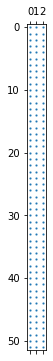

2m:  52
n:  3


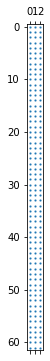

2m:  62
n:  3


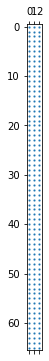

2m:  66
n:  3


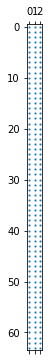

2m:  64
n:  3


In [25]:
s_list = []
for dense_block in tqdm(dense_blocks_list, total=len(dense_blocks_list)):
    y1, y2, x1, x2 = dense_block

    plt.figure(figsize=(6, 6))
    plt.spy(PVM_dense_cols[y1: y2, x1: x2], precision=1e-4, markersize=1)
    plt.show()
    
    S = factorize_and_stitch(PVM[y1: y2, x1: x2])
    s_list.append(S)

start allignment from the largest subblock

procrustes receives two matrices. each matrix, n rows represent points in k (columns) space

Thus, in practice, we pick an arbitrary block as root, and iteratively register all others with this one using linear least squares, before using a non-linear method to refine the global registration parameters.  

We choose the largest block as root node and use its coordinate system as the global frame. We then find the best path from the root to every other node using a measure that maximizes the number of points shared by adjacent blocks, the rationale being that large overlaps will give reliable estimates of the corresponding (local) registration parameters. Specifically, we assign to each edge a capacity (number of points common to the blocks associated with the incident vertices), and use a form of Dijkstra’s algorithm to find for each vertex the path maximizing the capacity reaching the root.

In [45]:
from sfm import allign_cloud_points_cumulatively

already_alligned_standardized = allign_cloud_points_cumulatively(s_list)

raw points_to_allign
 [[  9.25269441  -3.00353764  13.10311099  12.77894585 -25.0137384
   -4.20522968  -0.98767235 -19.48857497  -1.36476804 -26.79437363
   12.69666129   8.84808224 -12.71109624  12.98928197   7.41309934
   -6.76268963  10.34280345  12.90700104]
 [ -0.07132851  -8.89209884  -5.96461206  -5.89988204 -13.06849428
   11.30165752  13.28149827  -4.06256422  13.27318072 -13.27934757
   -5.78252853   0.20466791  20.05536502  -5.96733387   1.98777242
   10.57679048  -1.75883979  -5.93390263]
 [  1.66725569   8.9960765   -0.14199153  -4.81523685  10.20164919
   -4.21123632  17.19625452 -14.08085241   5.25204527  -0.7610505
   -3.30843655  -1.02152673  -4.24199851  -2.46207021   5.29725265
  -10.53131682   0.15977957  -3.19459694]]
accumulated shape: 3 procrusted with 18
Adding 15 zero points to the accumulated
Procrusting matrices of shapes (18, 3) and (18, 3)


raw points_to_allign
 [[  1.0747668  -16.22407893 -15.93289631  24.57236929   1.05892171
   -2.18351555  17.70071757

In [46]:
points = []

for mtx in already_alligned_standardized:
    p = o3d.geometry.PointCloud()
    p.points = o3d.utility.Vector3dVector(mtx)
    points.append(deepcopy(p))

In [47]:
o3d.visualization.draw_geometries(points) 

## 4 images

In [48]:
min_number_of_patches = 3
min_number_of_images = 4

dense_blocks_list = extract_dense_blocks(PVM_dense_cols, min_number_of_images=min_number_of_images,
                                         min_number_of_patches=min_number_of_patches,
                                         sparse_fill_value=sparse_fill_value)

in column 0 the longest sequence indices: [ 0 84]
dense block is rising
dense block is rising
in column 1 the longest sequence indices: [ 0 98]
dense block is rising
do not make a dense matrix from one patch
in column 2 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 3 the longest sequence indices: [ 0 66]
do not make a dense matrix from one patch
in column 4 the longest sequence indices: [ 0 62]
dense block is rising
do not make a dense matrix from one patch
in column 5 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 6 the longest sequence indices: [ 0 52]
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising


  0%|          | 0/10 [00:00<?, ?it/s]

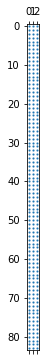

2m:  84
n:  3


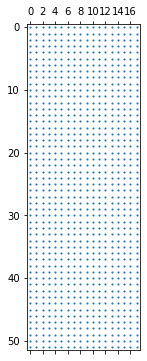

2m:  52
n:  18


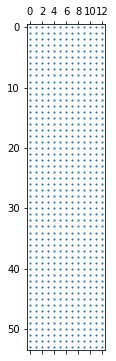

2m:  54
n:  13


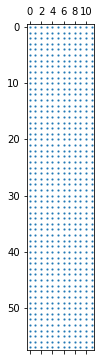

2m:  58
n:  12


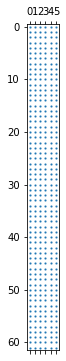

2m:  62
n:  6


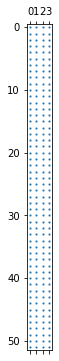

2m:  52
n:  4


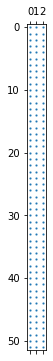

2m:  52
n:  3


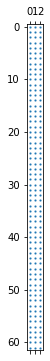

2m:  62
n:  3


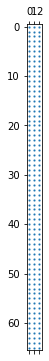

2m:  66
n:  3


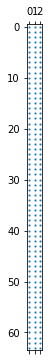

2m:  64
n:  3


In [49]:
s_list = []
for dense_block in tqdm(dense_blocks_list, total=len(dense_blocks_list)):
    y1, y2, x1, x2 = dense_block

    plt.figure(figsize=(6, 6))
    plt.spy(PVM_dense_cols[y1: y2, x1: x2], precision=1e-4, markersize=1)
    plt.show()
    
    S = factorize_and_stitch(PVM[y1: y2, x1: x2])
    s_list.append(S)

In [50]:
already_alligned_standardized = allign_cloud_points_cumulatively(s_list)

raw points_to_allign
 [[  9.25269441  -3.00353764  13.10311099  12.77894585 -25.0137384
   -4.20522968  -0.98767235 -19.48857497  -1.36476804 -26.79437363
   12.69666129   8.84808224 -12.71109624  12.98928197   7.41309934
   -6.76268963  10.34280345  12.90700104]
 [ -0.07132851  -8.89209884  -5.96461206  -5.89988204 -13.06849428
   11.30165752  13.28149827  -4.06256422  13.27318072 -13.27934757
   -5.78252853   0.20466791  20.05536502  -5.96733387   1.98777242
   10.57679048  -1.75883979  -5.93390263]
 [  1.66725569   8.9960765   -0.14199153  -4.81523685  10.20164919
   -4.21123632  17.19625452 -14.08085241   5.25204527  -0.7610505
   -3.30843655  -1.02152673  -4.24199851  -2.46207021   5.29725265
  -10.53131682   0.15977957  -3.19459694]]
accumulated shape: 3 procrusted with 18
Adding 15 zero points to the accumulated
Procrusting matrices of shapes (18, 3) and (18, 3)


raw points_to_allign
 [[  1.0747668  -16.22407893 -15.93289631  24.57236929   1.05892171
   -2.18351555  17.70071757

In [51]:
points = []

for mtx in already_alligned_standardized:
    p = o3d.geometry.PointCloud()
    p.points = o3d.utility.Vector3dVector(mtx)
    points.append(deepcopy(p))

o3d.visualization.draw_geometries(points) 